In [1]:
import numpy as np
import matplotlib.pyplot as plt
import openslide
import pandas as pd
import cv2 as cv
from skimage.color import rgb2lab, deltaE_ciede2000
from define_dataset import define_dataset
from color_distance import color_distance

Import data

In [2]:
dataset = define_dataset()
tr_set = dataset.tr_set
test_set = dataset.test_set
results_dict = dataset.results_dict
num_positives = dataset.num_positives
num_negatives = dataset.num_negatives

ROI identification function for a WSI

In [3]:
def calculate_ROI(wsi_path, full_tile_size, level, threshold_white, base_white):
    wsi = openslide.OpenSlide(wsi_path)
    width_in_tiles = int(wsi.dimensions[0]/full_tile_size)
    height_in_tiles = int(wsi.dimensions[1]/full_tile_size)
    #print('num tiles width', width_in_tiles)
    #print('num tiles heigth', height_in_tiles)
    
    level_tile_size = int(full_tile_size/(2**level))
    ROI_map_arr = np.empty([height_in_tiles, width_in_tiles], dtype=np.single)

    
    for x in range(width_in_tiles):
        print(wsi_path,': col ', x, ' of ', width_in_tiles, end="\r")
        for y in range(height_in_tiles):
            tile = wsi.read_region((x*full_tile_size,y*full_tile_size), level, (level_tile_size,level_tile_size))
            num_white_pixel = color_distance(tile, base_white, threshold_white)
            white_pixel_ratio = num_white_pixel/(tile.size[0]*tile.size[1])
            ROI_map_arr[y][x] = white_pixel_ratio
    return ROI_map_arr

Calcalculate ROI for TR set

In [4]:
level = 2
threshold_white = 5
#tile size at level 0 (full resolution)
full_tile_size = 512
base_white = [238,238,238]
for slide_name in test_set:
    wsi_path = '../WSI/thesis_WSI/'+slide_name+'/'+slide_name+'.tiff'
    ROI_map_arr = calculate_ROI(wsi_path, full_tile_size, level, threshold_white, base_white)
    np.save('../WSI/thesis_WSI/'+slide_name+'/roi.npy', ROI_map_arr)
    print('\n')
    print('completed slide: '+ slide_name)

KeyboardInterrupt: 

Loads nyp ROI map and shows it

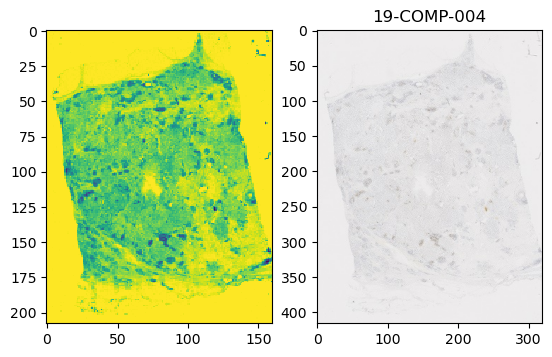

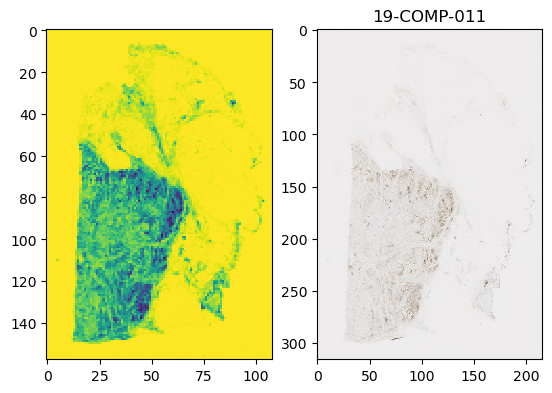

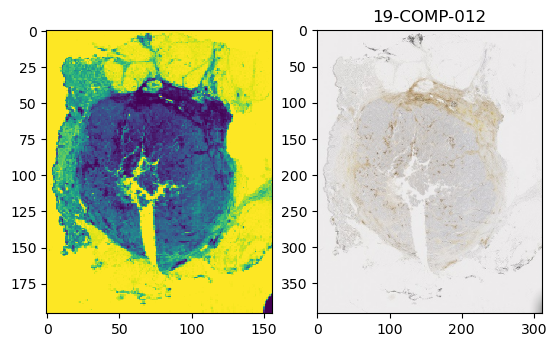

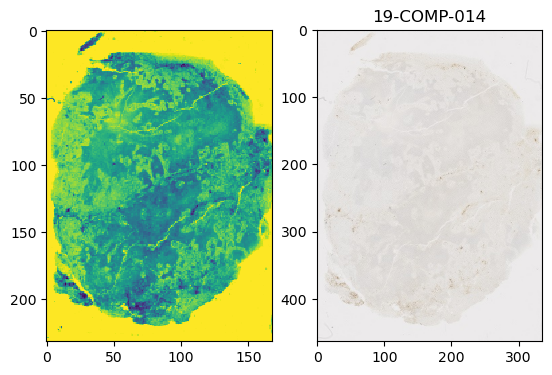

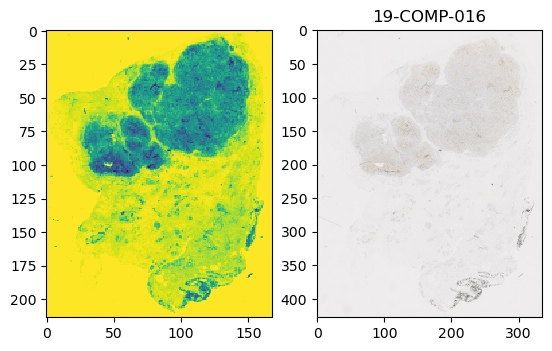

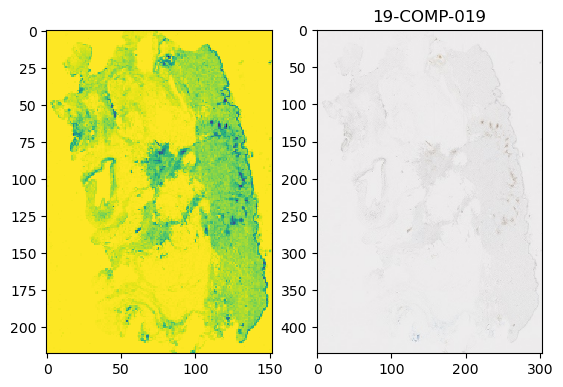

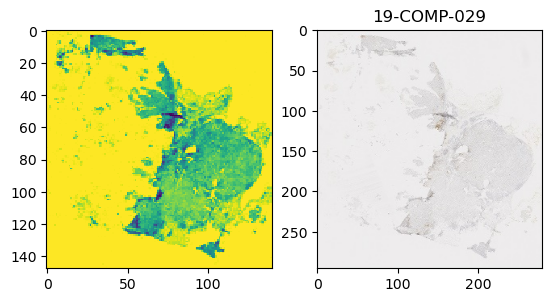

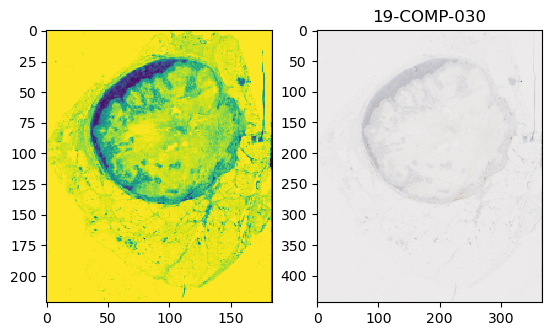

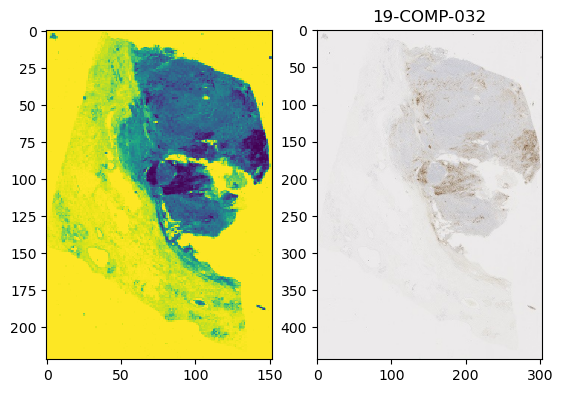

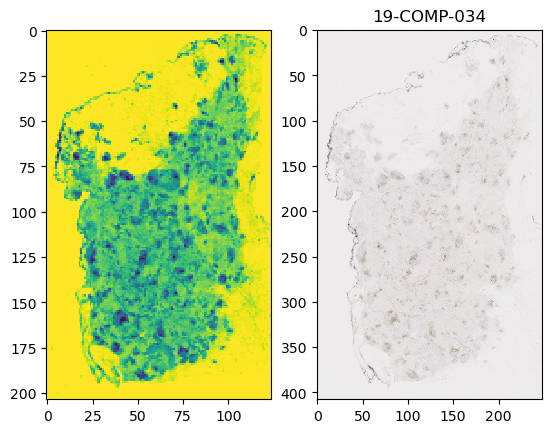

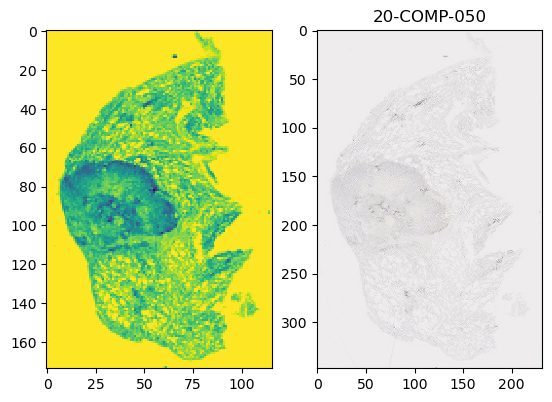

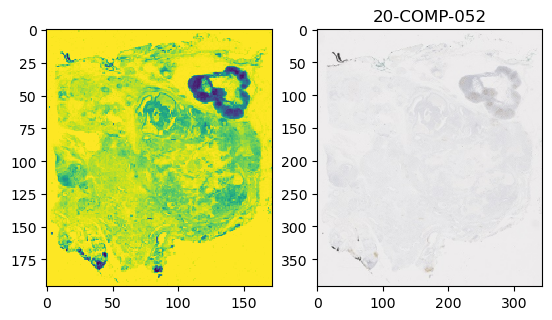

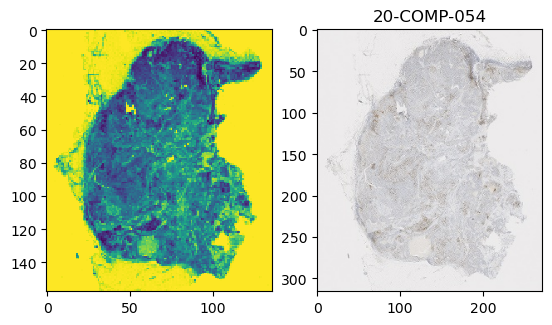

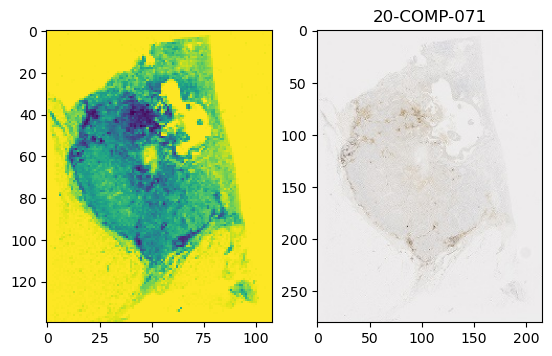

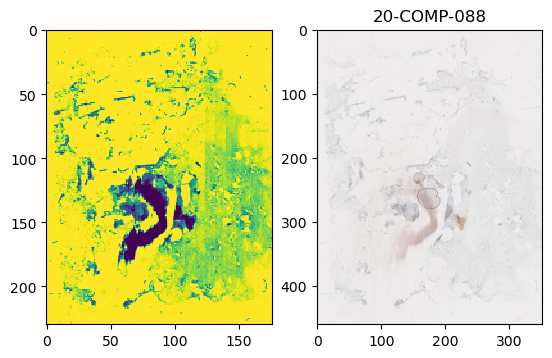

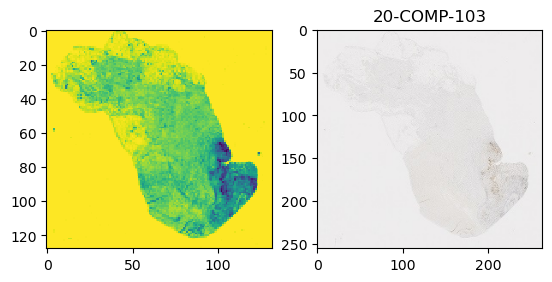

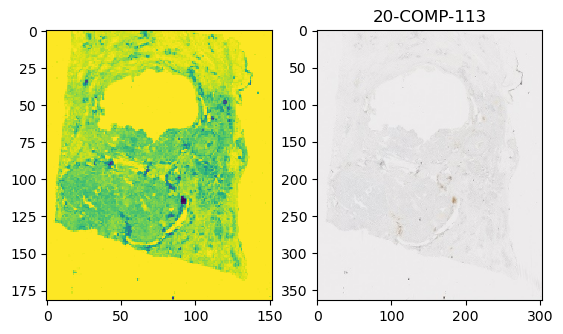

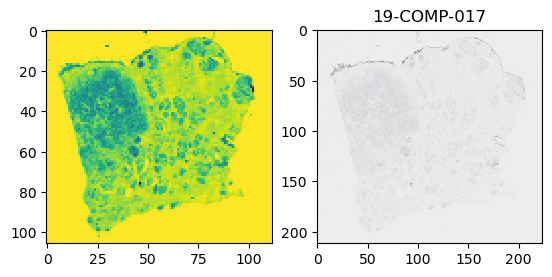

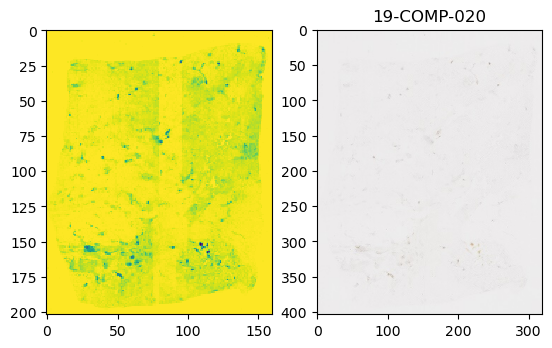

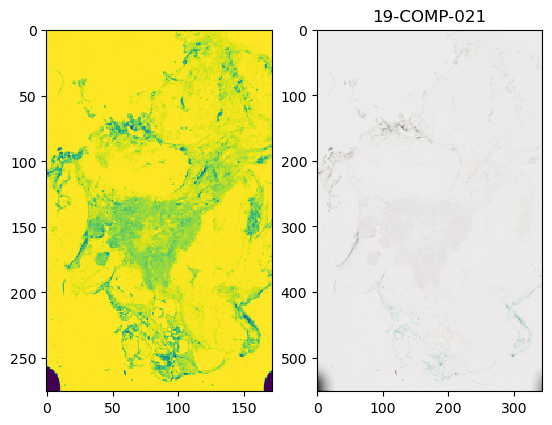

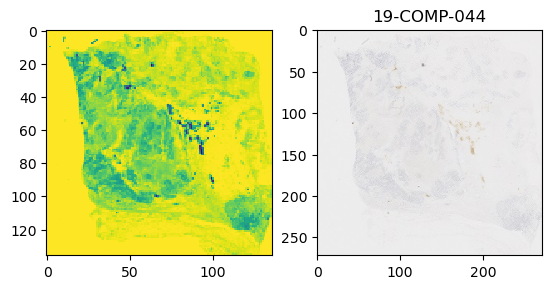

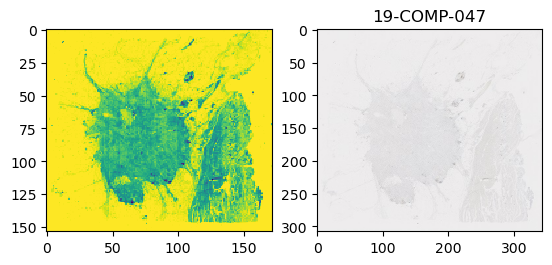

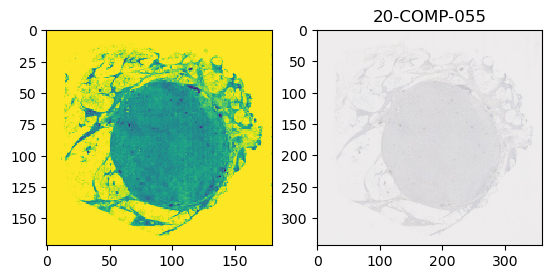

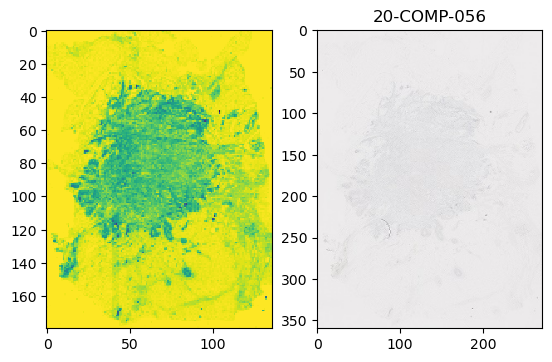

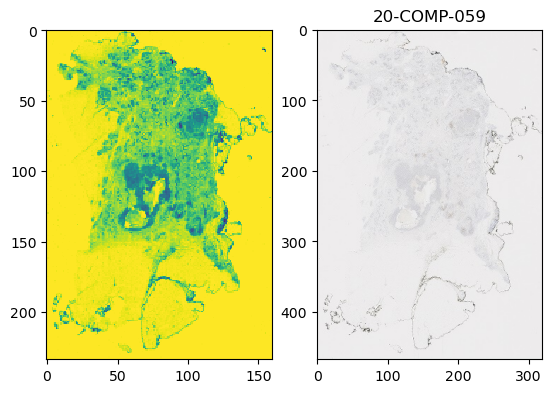

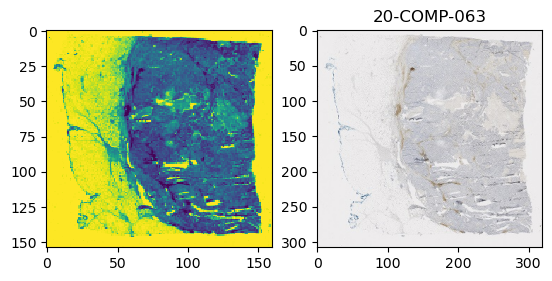

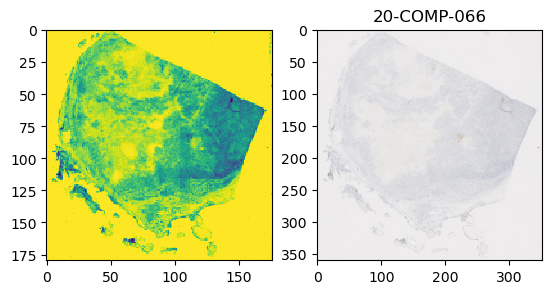

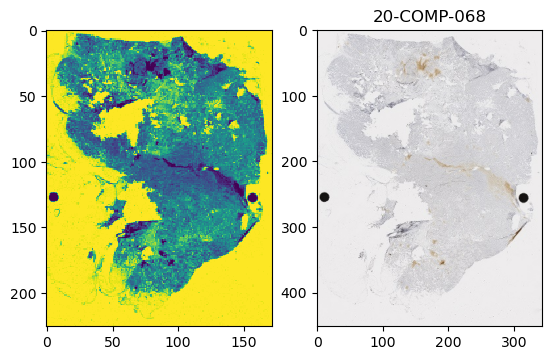

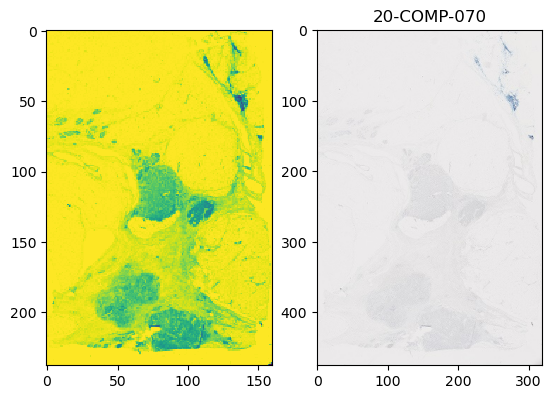

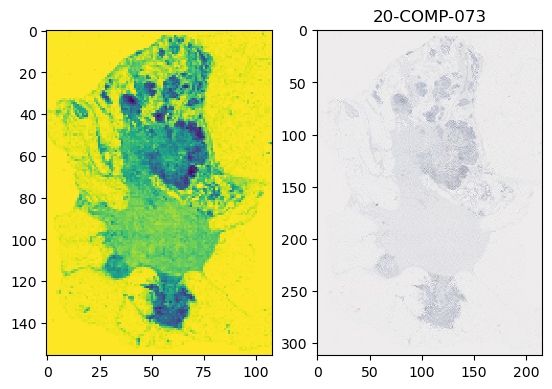

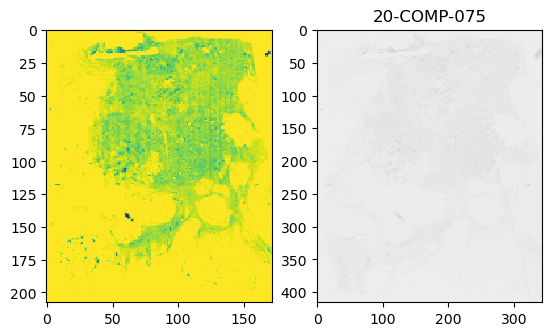

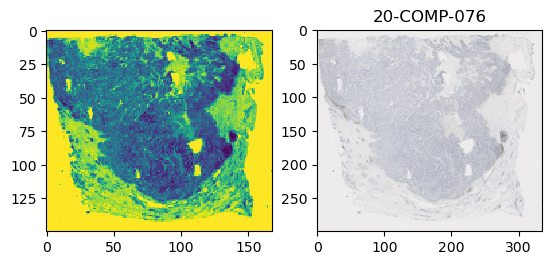

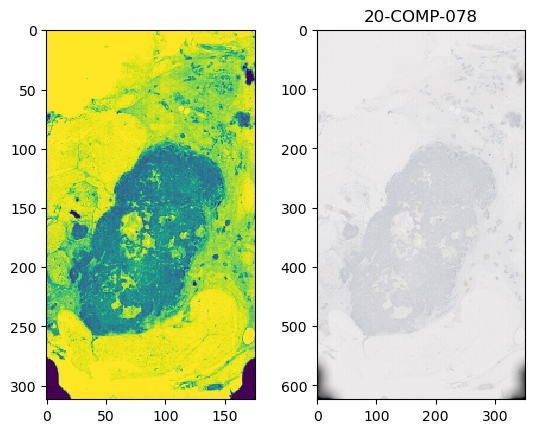

In [ ]:
for slide_name in tr_set: 
    ROI_map_path = '../WSI/thesis_WSI/'+slide_name+'/roi.npy'
    wsi_path = '../WSI/thesis_WSI/'+slide_name+'/'+slide_name+'.tiff'
    
    ROI_map_arr = np.load('../WSI/thesis_WSI/'+slide_name+'/roi.npy')
    thumbnail = openslide.OpenSlide(wsi_path).get_thumbnail((2*ROI_map_arr.shape[1], 2*ROI_map_arr.shape[0]))
    
    f, couple_im = plt.subplots(1,2)
    couple_im[0].imshow(ROI_map_arr, interpolation='nearest')
    couple_im[1].imshow(thumbnail)


    
    #plt.imshow(ROI_map_arr, interpolation='nearest')
    plt.title(slide_name)

    plt.show()

Shows ROI array of WSI with a threshold for close-to-white pixels percentage

In [1]:
tile_percentage_threshold = 0.85
for slide_name in tr_set:
    ROI_map_path = '../WSI/thesis_WSI/'+slide_name+'/roi.npy'
    ROI_map_arr = np.load('../WSI/thesis_WSI/'+slide_name+'/roi.npy')
    plt.imshow(ROI_map_arr<tile_percentage_threshold,  interpolation='nearest')
    plt.title(slide_name)
    #plt.imshow(ROI_map_arr, interpolation='nearest')

    plt.show()

NameError: name 'tr_set' is not defined

In [9]:
def exec_closing_opening(threshold_ROI_map):
    kernel = np.ones((3,3), np.uint8)
    
    #removes "holes" in ROI
    img_dilated1 = cv.dilate(threshold_ROI_map, kernel, iterations=1)
    img_eroded1 = cv.erode(img_dilated1, kernel, iterations=1)
    #removes "islands"
    img_eroded2 = cv.erode(img_eroded1, kernel, iterations=1)
    img_dilated2 = cv.dilate(img_eroded2, kernel, iterations=1)
    
    
    return img_dilated2.astype(int)

apply opening and closing to ROI map array with a threshold and save it

In [6]:
tile_percentage_threshold = 0.85
 
for slide_name in tr_set:
    ROI_map_path = '../WSI/thesis_WSI/'+slide_name+'/roi.npy'
    ROI_map_arr = np.load('../WSI/thesis_WSI/'+slide_name+'/roi.npy')
    
    threshold_ROI_map = (ROI_map_arr<tile_percentage_threshold).astype(float)     
    ROI_map_op_cl = exec_closing_opening(threshold_ROI_map)
    np.save('../WSI/thesis_WSI/'+slide_name+'/roi_'+str(tile_percentage_threshold)+'.npy', ROI_map_op_cl)

    

NameError: name 'exec_closing_opening' is not defined

Show ROI map array after opening and closing with a certain threshold

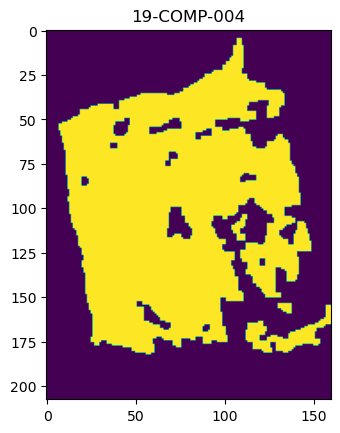

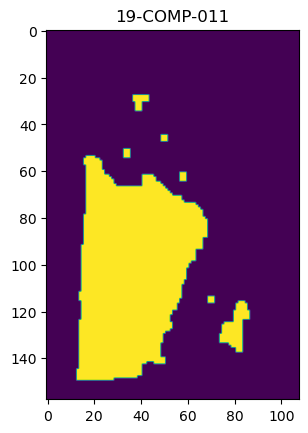

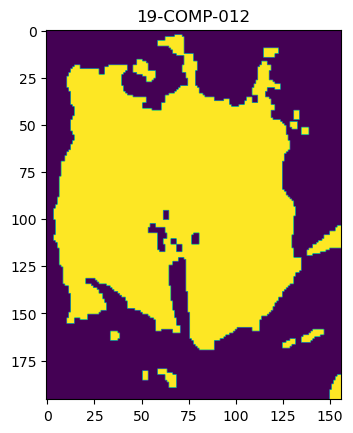

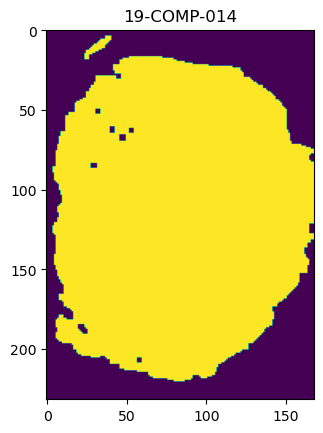

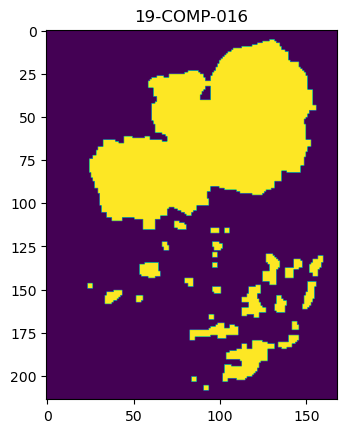

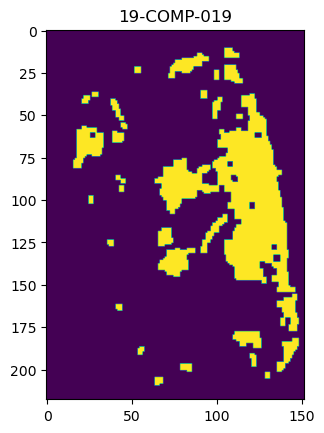

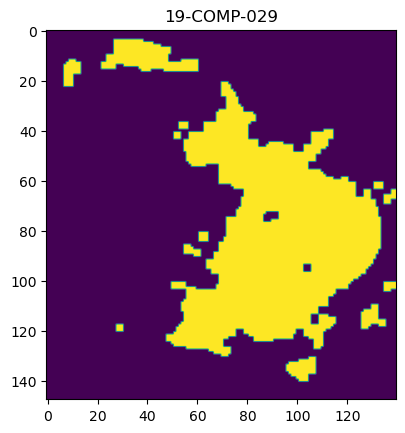

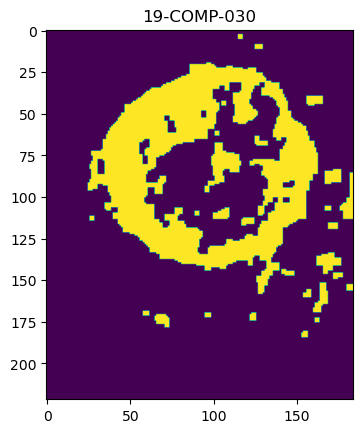

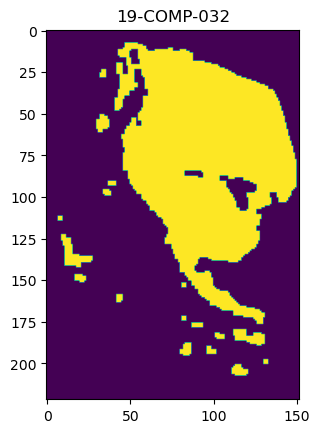

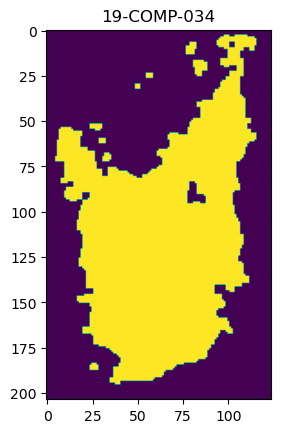

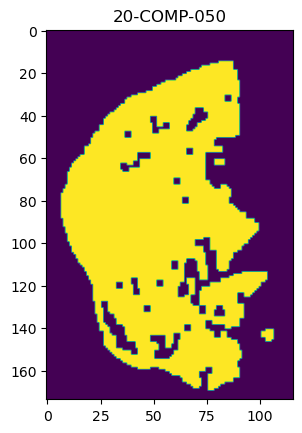

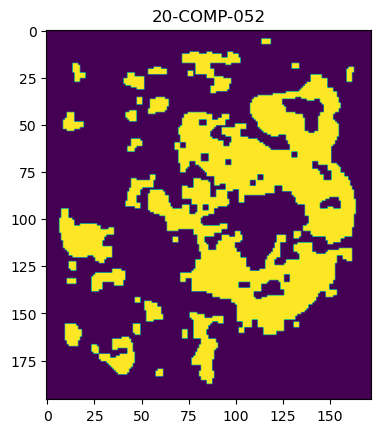

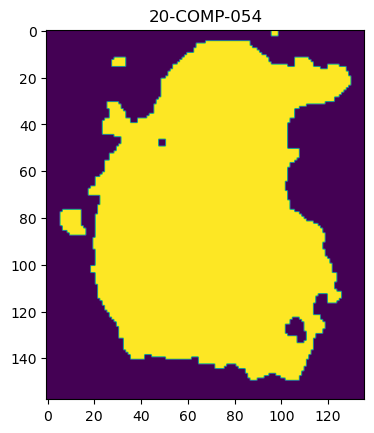

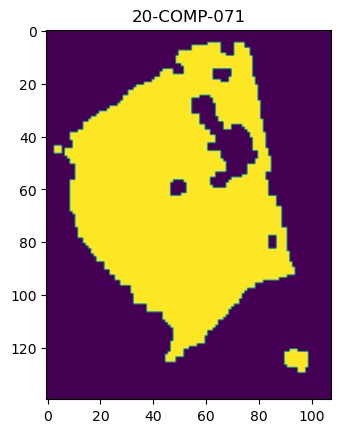

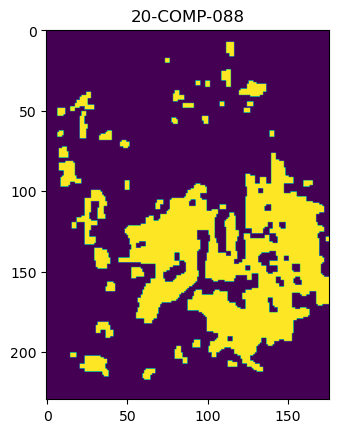

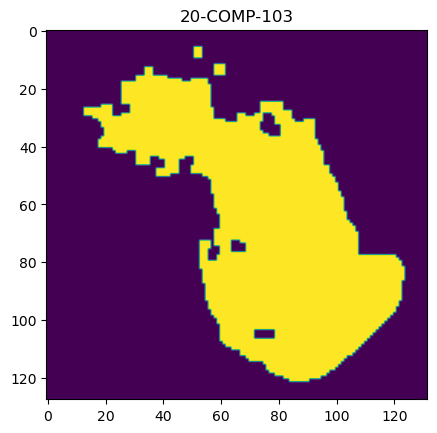

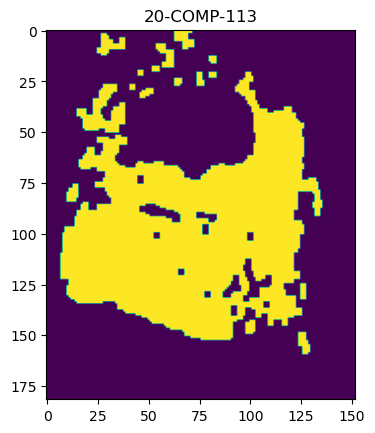

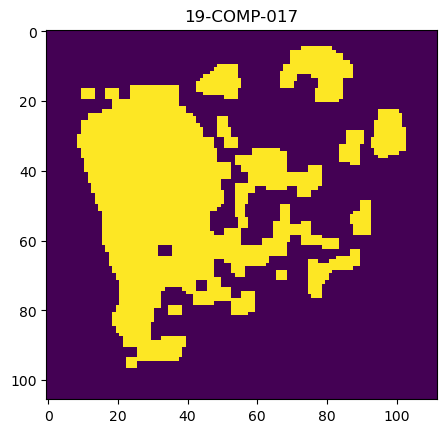

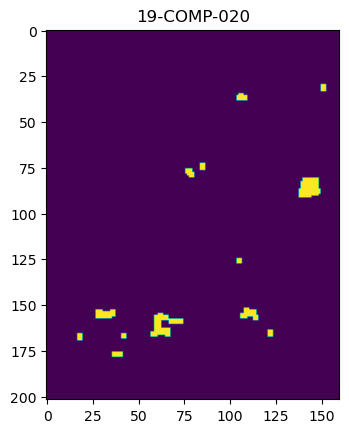

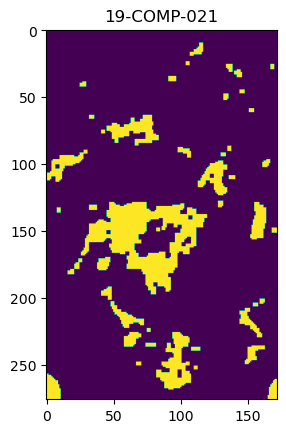

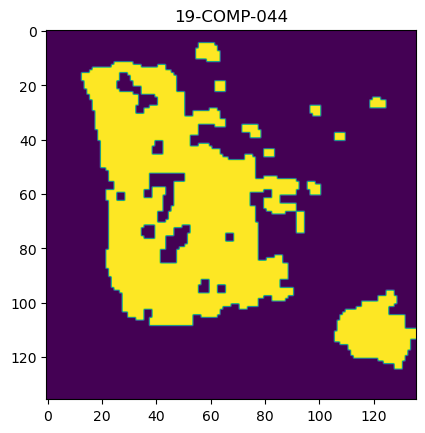

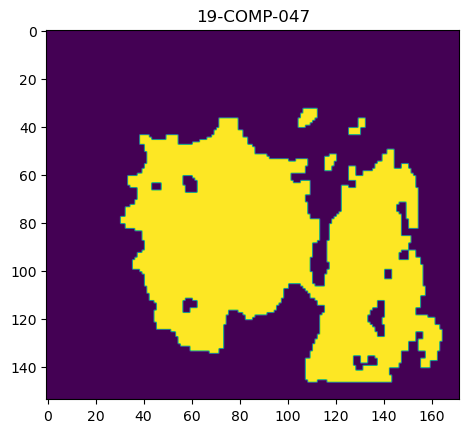

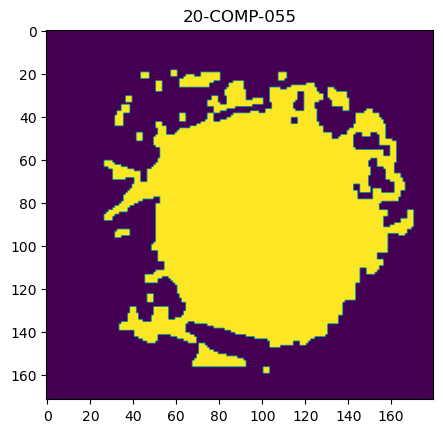

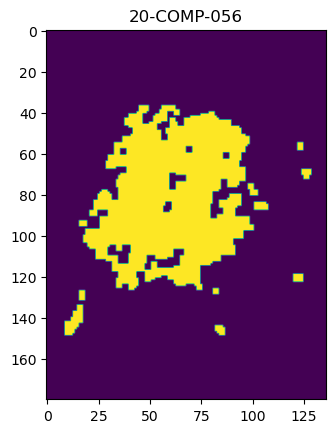

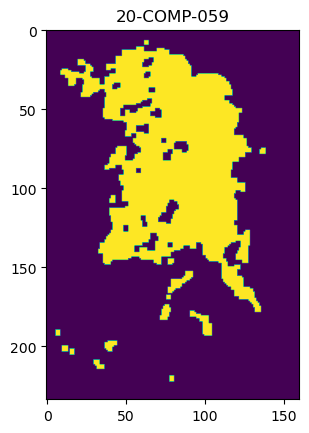

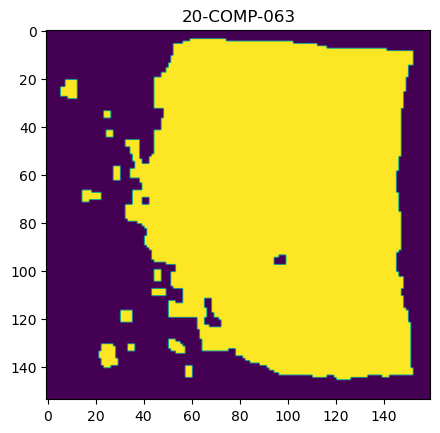

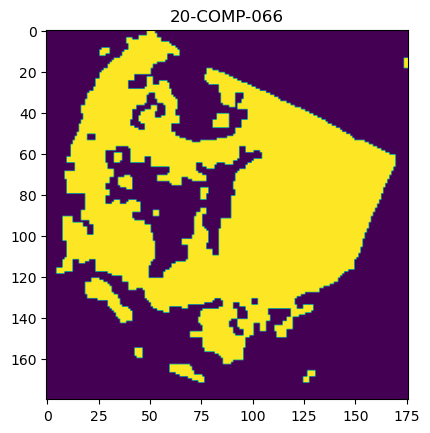

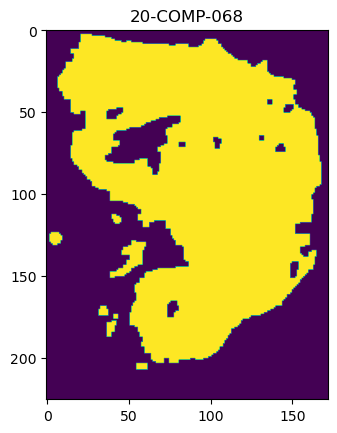

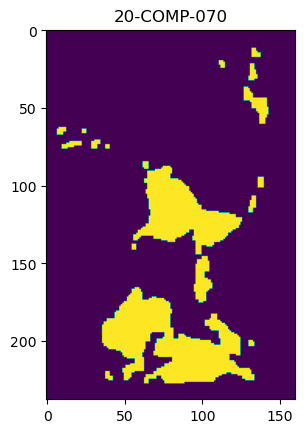

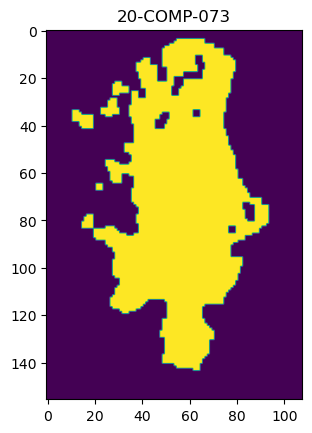

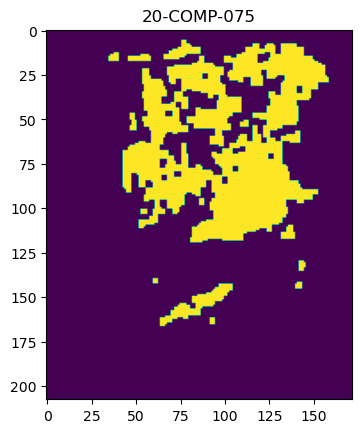

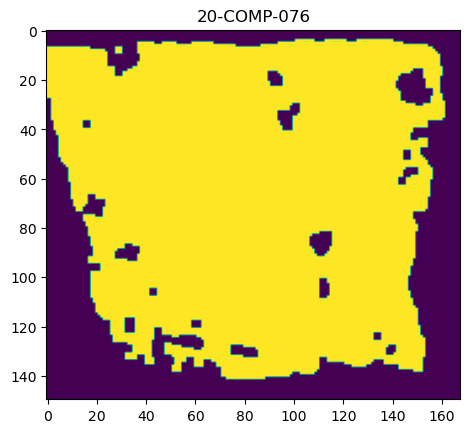

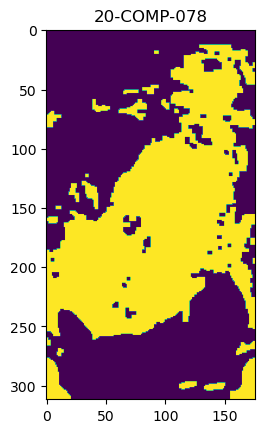

In [15]:
tile_percentage_threshold = 0.85

for slide_name in tr_set:
    ROI_map_op_cl = np.load('../WSI/thesis_WSI/'+slide_name+'/roi_'+str(tile_percentage_threshold)+'.npy')
    plt.imshow(ROI_map_op_cl)
    plt.title(slide_name)
    plt.show()